In [1]:
import torch
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings

from models.pipeline import Pipeline
from utils.view import draw_grid, draw_task
from utils.latent_space import grid_to_latent, latent_to_grid, process_train_pairs, reconstruct_grid
from utils.linear_solver import visual_analogy_single_task

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vae_v2_vampprior import ConvolutionalVAEV2_VampPrior
from models.convolutional_vae_v2_vampprior import preprocess_grid as preprocess_grid_vp, postprocess_grid as postprocess_grid_vp
from models.convolutional_vae_v3 import ConvolutionalVAEV3
from models.convolutional_vae_v3 import preprocess_grid as preprocess_vaev3, postprocess_grid as postprocess_vaev3
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq
from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=512,
    feature_dim=[8, 8]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev2_512_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [3]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

In [4]:
def compute_accuracy(original, decoded):
    correct = (original == decoded)
    accuracy = correct.mean().item()
    is_perfect = accuracy == 1.0
    return accuracy, is_perfect

def get_tasks_with_output_reconstruction(data, pipeline, model_type):
    df = pd.DataFrame(columns=['puzzle_id', 'train_pairs_recon_accuracy', 'input_recon_accuracy', 'output_recon_accuracy', 'avg_accuracy'])
    
    for puzzle_id, task in data.items():
        train_accuracies = []
        for train_input, train_output in task['train']:
            recon_input = reconstruct_grid(pipeline, train_input, model_type)
            input_acc, _ = compute_accuracy(train_input, recon_input)
            train_accuracies.append(input_acc)

            recon_output = reconstruct_grid(pipeline, train_output, model_type)
            output_acc, _ = compute_accuracy(train_output, recon_output)
            train_accuracies.append(output_acc)


        test_input, test_output = task['test'][0]

        input_recon = reconstruct_grid(pipeline, test_input, model_type)
        output_recon = reconstruct_grid(pipeline, test_output, model_type)

        input_recon_acc, _ = compute_accuracy(test_input, input_recon)        
        test_output_acc, _ = compute_accuracy(test_output, output_recon)


        df.loc[len(df)] = [puzzle_id, np.mean(train_accuracies), input_recon_acc, test_output_acc, np.mean(train_accuracies + [input_recon_acc, test_output_acc])]

    return df

In [5]:
tasks_df = get_tasks_with_output_reconstruction(data, pipeline, model_type)

In [8]:
reconstructable_ids = set(tasks_df[tasks_df['avg_accuracy'] == 1.0]['puzzle_id'])
# for puzzle_id in reconstructable_ids:
#     draw_task(data[puzzle_id], task_id=puzzle_id)

In [9]:
all_grids = [grid for task in data.values() for pair in task['train'] + task['test'] for grid in pair]
z_all = torch.cat([grid_to_latent(pipeline, grid, model_type)[0] for grid in all_grids], dim=0)
z_all = z_all.detach().cpu().numpy()

In [10]:
umap_metrics = [
    'euclidean',
    'canberra',
    'cosine'
]

reducer_by_metric = {}

for metric in umap_metrics:
    reducer = umap.UMAP(
        n_components=2, 
        min_dist=0.0,
        n_neighbors=15,
        metric=metric, 
        random_state=42
    )

    reducer.fit(z_all)
    reducer_by_metric[metric] = reducer

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
def visualize_task(reducer, z_example, example_labels, arrows, z_matched_samples, matched_labels, title=""):
    latent_example_2d = reducer.transform(z_example)

    x_range = latent_example_2d[:, 0].max() - latent_example_2d[:, 0].min()
    y_range = latent_example_2d[:, 1].max() - latent_example_2d[:, 1].min()

    scale = (x_range + y_range) / 2
    arrow_head_width = 0.01 * scale 
    arrow_head_length = 0.05 * scale
    
    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap('tab20')

    # for idx, _ in enumerate(z_example):
    #     plt.scatter(latent_example_2d[idx, 0], latent_example_2d[idx, 1], c=cmap(idx + 1 % 20), s=10, label=example_labels[idx])    
    
    # print(len(matched_labels))
    for i, label in enumerate(matched_labels):
        matched_2d = reducer.transform(z_matched_samples[i].reshape(1, -1))[0]
        plt.scatter(matched_2d[0], matched_2d[1], c=cmap(label % 20), s=10, label=example_labels[label - 1])

    for (i,j) in arrows:
        start = latent_example_2d[i]
        end = latent_example_2d[j]
        plt.arrow(start[0], start[1],
                end[0] - start[0], end[1] - start[1],
                head_width=arrow_head_width,
                head_length=arrow_head_length,
                length_includes_head=True, color='black', alpha=0.8)
        
    legend_entries = {}
    for label in set(matched_labels):
        color = cmap(label % 20)
        legend_entries[example_labels[label - 1]] = color

    handles = [mpatches.Patch(color=color, label=name) for name, color in legend_entries.items()]
    plt.legend(handles=handles, title="Matched Samples")
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [17]:
comps = ['average', 'scaled_euc', 'scaled_cos']
def get_examples(task, model_type):
    examples = []
    labels = []


    for idx,(train_input, train_output) in enumerate(task['train']):
        examples.append(train_input)
        labels.append(f'Train Input {idx+1}')
        examples.append(train_output)
        labels.append(f'Train Output {idx+1}')

    test_input, test_output = task['test'][0]
    examples.append(test_input)
    labels.append('Test Input')
    examples.append(test_output)
    labels.append('Test Output')    

    arrows = []
    for i in range(int(len(examples)/2)):
        arrows.append((i*2, i*2 + 1))

    test_input_index = len(examples) - 2
    for comp in comps:
        pred, _ = visual_analogy_single_task(
            pipeline,
            task['train'],
            task['test'][0],
            model_type,
            comp=comp,
        )
        examples.append(pred)
        labels.append(f'Predicted Output ({comp})')
        arrows.append((test_input_index, len(examples) - 1))

    return examples, labels, arrows

In [18]:
def matches_example_grid(decoded_grid, example_grid):
    decoded_grid = np.array(decoded_grid)
    grid = np.array(example_grid)

    return (decoded_grid.shape == grid.shape and (decoded_grid == grid).mean() == 1.0)
    
def label_decoded_samples_single_grid(z_samples, example_grid, label, pipeline, model_type):
    matched_z = []
    labels = []
    for z in z_samples:
        z_tensor = torch.from_numpy(z).float()
        # issue here - doesn't work with different example grid sizes
        decoded = latent_to_grid(pipeline, z_tensor, example_grid, model_type)
        p = matches_example_grid(decoded, example_grid)
        # print(p)
        if p:
            matched_z.append(z)
            labels.append(label)
            
    return np.array(matched_z), labels

In [19]:
def sample_nearby(z_values, num_samples_per_point=50, std_dev=0.1, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    z_values = np.atleast_2d(z_values)  # Ensure shape (N, D)
    N, D = z_values.shape

    # Generate noise of shape (N, num_samples_per_point, D)
    noise = np.random.normal(scale=std_dev, size=(N, num_samples_per_point, D))
    nearby_samples = z_values[:, np.newaxis, :] + noise  # shape: (N, num_samples_per_point, D)

    # Concatenate the original points to the beginning of the samples
    combined = np.concatenate([z_values[:, np.newaxis, :], nearby_samples], axis=1)  # shape: (N, num_samples_per_point + 1, D)

    return combined

Visualizing task d017b73f...


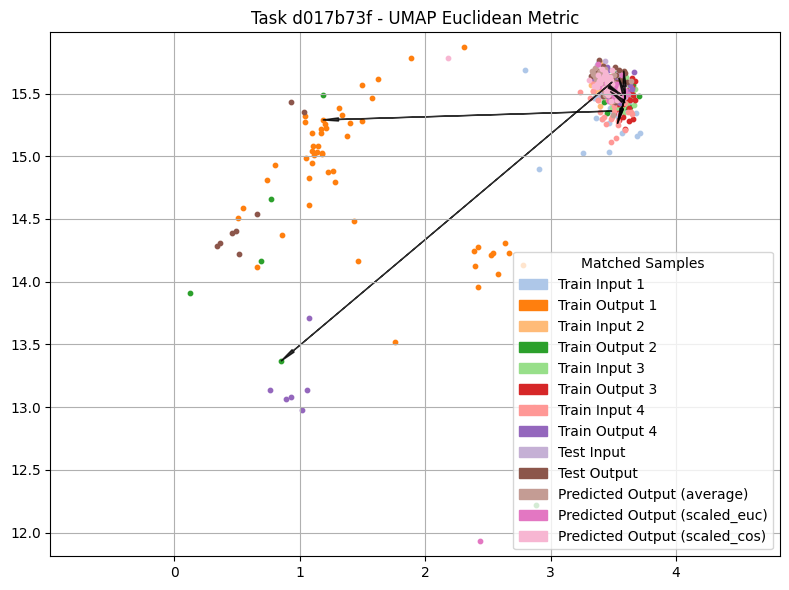

Visualizing task 0692e18c...


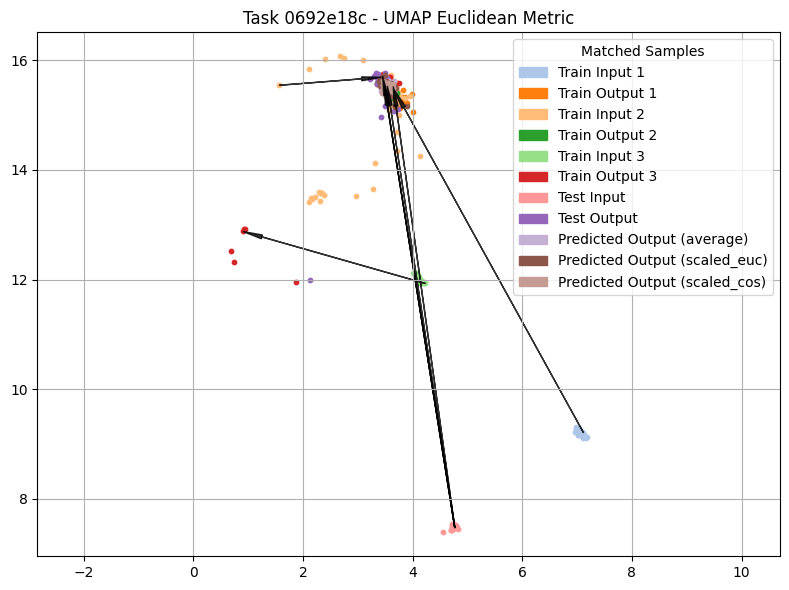

In [20]:
counter = 0
for puzzle_id, task in data.items():
    if puzzle_id not in reconstructable_ids:
        continue
    
    if counter > 1:
        break
    counter +=1
    print(f"Visualizing task {puzzle_id}...")
    
    examples, labels, arrows = get_examples(task, model_type)
    z_examples = torch.cat([grid_to_latent(pipeline, grid, model_type)[0] for grid in examples], dim=0)
    z_examples = z_examples.detach().cpu().numpy()
    
    z_matched_samples = []
    matched_labels = []
    z_samples = sample_nearby(z_examples)

    for idx, z_example in enumerate(z_examples):
        z_s = z_samples[idx]     

        z_m, m_labels = label_decoded_samples_single_grid(z_s, examples[idx], idx + 1, pipeline, model_type)
        
        z_matched_samples.extend(z_m)
        matched_labels.extend(m_labels)

    metric = 'euclidean'  # Change this to visualize different metrics
    visualize_task(
        reducer_by_metric[metric], 
        z_examples, 
        labels, 
        arrows, 
        z_matched_samples, 
        matched_labels,
        title=f"Task {puzzle_id} - UMAP {metric.title()} Metric"
    )

    
